In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install split-folders

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import splitfolders
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras.utils import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-10-23 07:35:49.499615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761204949.692063      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761204949.749374      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
IMAGES_FOLDERS_PATH = '/kaggle/input/plantdisease/PlantVillage'
OUTPUT_FOLDER = 'plantdisease_split'
BATCH_SIZE = 64
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
EPOCHS = 100

Classes Number: 15


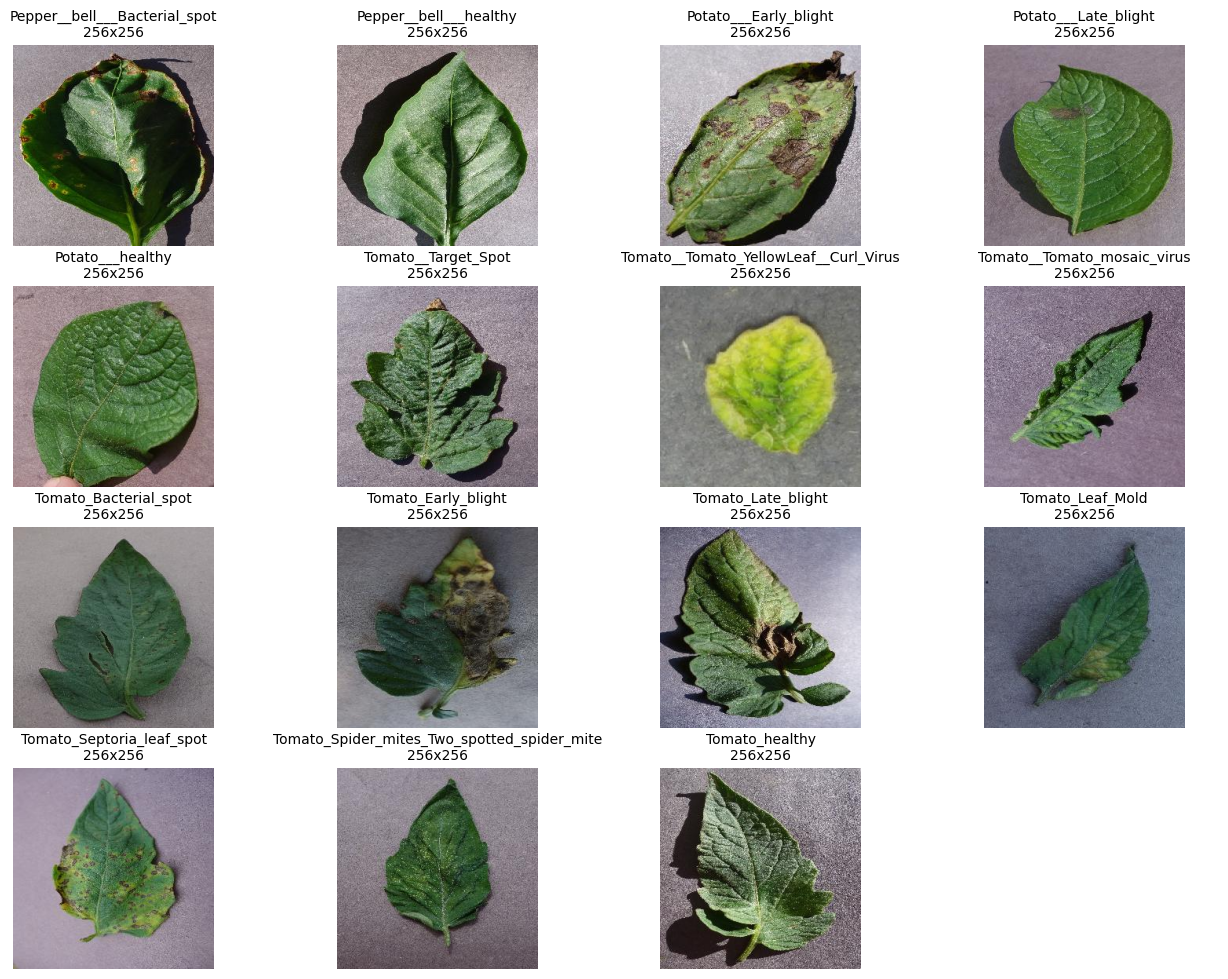

In [5]:
def VisualizeClasses(folders_path):
    # Get all class folders and sort them
    ClassesNames = os.listdir(folders_path)
    ClassesNames.sort(key=lambda x: (x.split('__')[0], x))
    
    # Display the total number of classes
    NUM_CLASSES = len(ClassesNames)
    print(f"Classes Number: {NUM_CLASSES}")
    
    # Prepare the grid for showing sample images
    cols = 4
    rows = (NUM_CLASSES + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
    axes = axes.flatten()
    
    # Show one sample image from each class
    for i, cat in enumerate(ClassesNames):
        ClassFolderPath = os.path.join(folders_path,cat)
        ImagesName = os.listdir(ClassFolderPath)
        img_path = os.path.join(ClassFolderPath,ImagesName[0])
        with Image.open(img_path) as img:
            width, height = img.size
        image = mpimg.imread(img_path)
        axes[i].imshow(image)
        axes[i].set_title(f"{cat}\n{width}x{height}", fontsize=10)
        axes[i].axis('off')
        
    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

# Call the function to visualize all classes
VisualizeClasses(IMAGES_FOLDERS_PATH)   



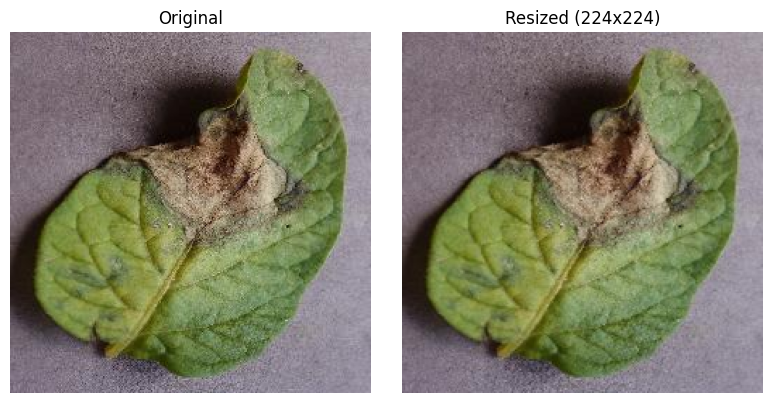

In [6]:
# Pick a random class folder
ClassesNames = os.listdir(IMAGES_FOLDERS_PATH)
random_class = random.choice(ClassesNames)
class_path = os.path.join(IMAGES_FOLDERS_PATH, random_class)

# Pick a random image from that class
images = os.listdir(class_path)
random_image = random.choice(images)
img_path = os.path.join(class_path, random_image)

# Open and resize the selected image to 224x224
with Image.open(img_path) as img:
    resized_img = img.resize((WIDTH, HEIGHT)) 

# Display the original and resized images side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(mpimg.imread(img_path))
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(resized_img)
axes[1].set_title(f"Resized ({WIDTH}x{HEIGHT})")
axes[1].axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


In [8]:
# Split the dataset into training (80%) and validation (20%) folders
splitfolders.ratio(IMAGES_FOLDERS_PATH, output=OUTPUT_FOLDER, seed=42, ratio=(0.8, 0.2))


Copying files: 20639 files [02:11, 156.46 files/s]


In [9]:
# Define the training and validation dataset paths
TRAIN_FOLDER_PATH = '/kaggle/working/plantdisease_split/train'
VAL_FOLDER_PATH = '/kaggle/working/plantdisease_split/val'

# Data augmentation for training images (adds variations to improve generalization)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Apply MobileNetV3 preprocessing
    rotation_range=20, # Random rotations
    width_shift_range=0.2, # Horizontal shifts
    height_shift_range=0.2, # Vertical shifts
    shear_range=0.2, # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest' # Fill missing pixels after transformations
)
train_image_generator = train_datagen.flow_from_directory(
                                            TRAIN_FOLDER_PATH,
                                            target_size=(WIDTH, HEIGHT), # Resize all images to 224x224
                                            batch_size= BATCH_SIZE, # Number of images per batch
                                            class_mode='categorical') # Multi-class classification


# Validation images (no augmentation, only preprocessing)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_image_generator = val_datagen.flow_from_directory(
                                            VAL_FOLDER_PATH,
                                            target_size=(WIDTH, HEIGHT),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical')





Found 16504 images belonging to 15 classes.
Found 4134 images belonging to 15 classes.


In [10]:
class_names = list(val_image_generator.class_indices.keys()) 
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [11]:
# Load the MobileNetV3-Large model pre-trained on ImageNet (without the top classification layer)
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, CHANNELS))

# Freeze the base model layers to keep pretrained weights during initial training
base_model.trainable = False

# Build the new model on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(train_image_generator.num_classes,activation='softmax')) #Output layer for classification

model.summary()



I0000 00:00:1761205188.535421      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,623,567 (13.82 MB)

 Trainable params: 627,215 (2.39 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [12]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,              # Stop if no improvement for 5 epochs
    restore_best_weights=True # Restore the model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(
    train_image_generator,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = early_stopping,
    validation_data = val_image_generator
)

Epoch 1/100


I0000 00:00:1761205207.896011     120 service.cc:148] XLA service 0x7f533c002b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761205207.896900     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761205209.197232     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/258 ━━━━━━━━━━━━━━━━━━━━ 1:13:35 17s/step - accuracy: 0.0469 - loss: 3.2387

I0000 00:00:1761205215.337577     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


258/258 ━━━━━━━━━━━━━━━━━━━━ 221s 793ms/step - accuracy: 0.3817 - loss: 2.0031 - val_accuracy: 0.7871 - val_loss: 0.7442
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 188s 729ms/step - accuracy: 0.7458 - loss: 0.7987 - val_accuracy: 0.8595 - val_loss: 0.4530
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 187s 723ms/step - accuracy: 0.8201 - loss: 0.5527 - val_accuracy: 0.8921 - val_loss: 0.3475
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 188s 727ms/step - accuracy: 0.8533 - loss: 0.4531 - val_accuracy: 0.9081 - val_loss: 0.2939
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 188s 727ms/step - accuracy: 0.8766 - loss: 0.3757 - val_accuracy: 0.9216 - val_loss: 0.2585
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 189s 731ms/step - accuracy: 0.8879 - loss: 0.3448 - val_accuracy: 0.9315 - val_loss: 0.2229
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 187s 723ms/step - accuracy: 0.9029 - loss: 0.3013 - val_accuracy: 0.9337 - val_loss: 0.2094
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 189s 734ms/step - accuracy: 0.9068 - los

In [13]:
# Save the trained model before applying fine-tuning
model.save("mobilenetv3_before_finetuning.keras")

In [14]:
# Unfreeze the last 30 layers of the base model to fine-tune higher-level features
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train (fine-tune) the model again on the training data
fine_tune_history = model.fit(
    train_image_generator,
    validation_data=val_image_generator,
    epochs=EPOCHS,
    callbacks = early_stopping,
    verbose=1
)

Epoch 1/100


E0000 00:00:1761211235.989324     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761211236.187305     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


119/258 ━━━━━━━━━━━━━━━━━━━━ 1:32 668ms/step - accuracy: 0.8550 - loss: 0.5169

E0000 00:00:1761211322.663575     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761211322.864222     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


258/258 ━━━━━━━━━━━━━━━━━━━━ 215s 754ms/step - accuracy: 0.8884 - loss: 0.3778 - val_accuracy: 0.9018 - val_loss: 0.3585
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 184s 713ms/step - accuracy: 0.9616 - loss: 0.1171 - val_accuracy: 0.9153 - val_loss: 0.2949
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 184s 713ms/step - accuracy: 0.9701 - loss: 0.0848 - val_accuracy: 0.9386 - val_loss: 0.1900
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 184s 713ms/step - accuracy: 0.9759 - loss: 0.0694 - val_accuracy: 0.9572 - val_loss: 0.1319
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 188s 730ms/step - accuracy: 0.9784 - loss: 0.0638 - val_accuracy: 0.9666 - val_loss: 0.1051
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 188s 727ms/step - accuracy: 0.9817 - loss: 0.0581 - val_accuracy: 0.9654 - val_loss: 0.1054
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 188s 728ms/step - accuracy: 0.9868 - loss: 0.0413 - val_accuracy: 0.9698 - val_loss: 0.0986
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 187s 727ms/step - accuracy: 0.9879 - los

In [15]:
# Save the trained model after applying fine-tuning
model.save("mobilenetv3_after_finetuning.keras")


In [16]:
model_before = load_model("mobilenetv3_before_finetuning.keras")
loss, accuracy = model_before.evaluate(val_image_generator, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.9631 - loss: 0.1026
Test Accuracy: 96.49%
Test Loss: 0.1062


In [17]:
model_after = load_model("mobilenetv3_after_finetuning.keras")
loss, accuracy = model_after.evaluate(val_image_generator, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.9888 - loss: 0.0351
Test Accuracy: 98.81%
Test Loss: 0.0353


In [18]:
val_image_generator.shuffle = False
pred_before = model_before.predict(val_image_generator)


65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step


In [19]:
pred_after = model_after.predict(val_image_generator)

65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step


<Figure size 1200x500 with 0 Axes>

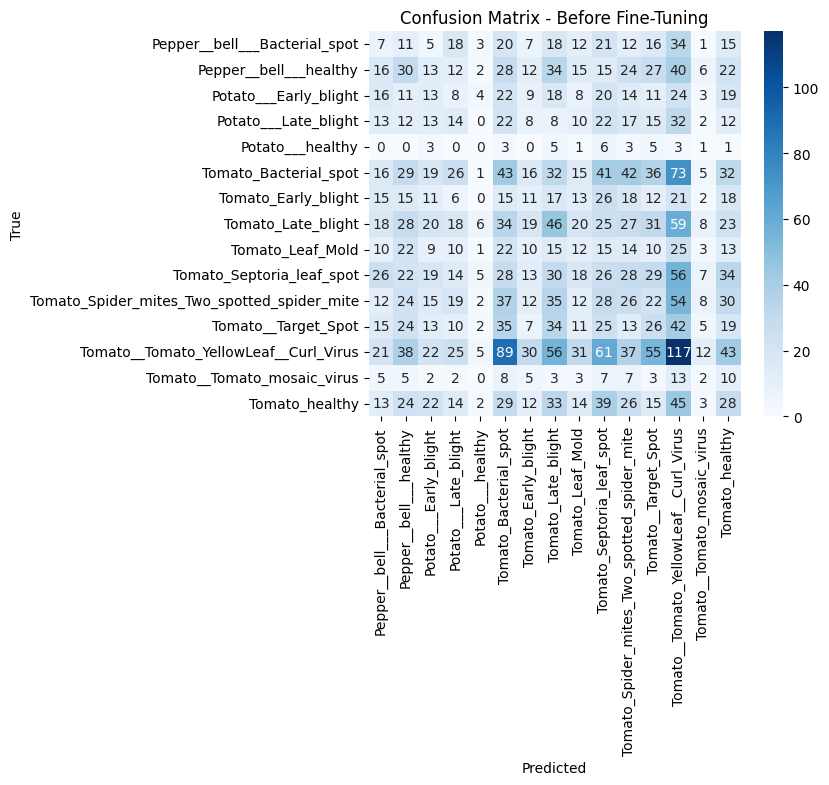

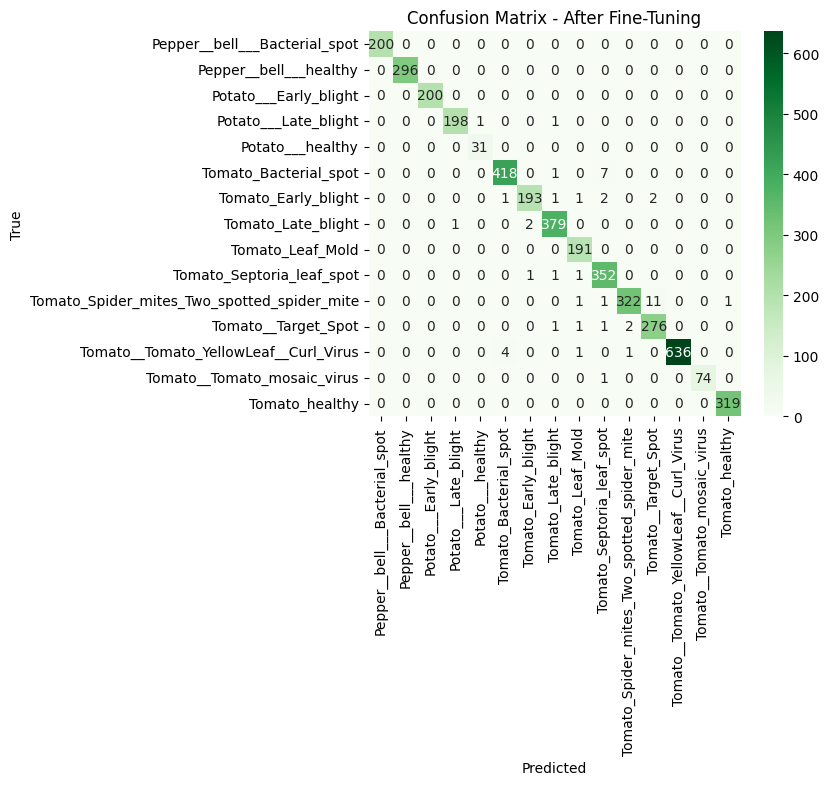

In [20]:
true_labels = val_image_generator.classes

pred_before_classes = np.argmax(pred_before, axis=1)
pred_after_classes = np.argmax(pred_after, axis=1)

cm_before = confusion_matrix(true_labels, pred_before_classes)
cm_after = confusion_matrix(true_labels, pred_after_classes)

plt.figure(figsize=(12, 5))

# ---------- FIGURE 1 (Before) ----------
plt.figure(figsize=(6, 5))
sns.heatmap(cm_before, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Before Fine-Tuning")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---------- FIGURE 2 (After) ----------
plt.figure(figsize=(6, 5))
sns.heatmap(cm_after, annot=True, fmt="d", cmap="Greens",
             xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - After Fine-Tuning")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [21]:
# ---- Classification Report ----
report = classification_report(true_labels, pred_before_classes, target_names=class_names)
print("\nClassification Report Before Fine-Tuning :")
print(report)


Classification Report Before Fine-Tuning :
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.03      0.04      0.03       200
                     Pepper__bell___healthy       0.10      0.10      0.10       296
                      Potato___Early_blight       0.07      0.07      0.07       200
                       Potato___Late_blight       0.07      0.07      0.07       200
                           Potato___healthy       0.00      0.00      0.00        31
                      Tomato_Bacterial_spot       0.10      0.10      0.10       426
                        Tomato_Early_blight       0.06      0.06      0.06       200
                         Tomato_Late_blight       0.12      0.12      0.12       382
                           Tomato_Leaf_Mold       0.06      0.06      0.06       191
                  Tomato_Septoria_leaf_spot       0.07      0.07      0.07       355
Tomato_Spider_mites_

In [22]:
# ---- Classification Report ----
report = classification_report(true_labels, pred_after_classes, target_names=class_names)
print("\nClassification Report After Fine-Tuning :")
print(report)


Classification Report After Fine-Tuning :
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       200
                     Pepper__bell___healthy       1.00      1.00      1.00       296
                      Potato___Early_blight       1.00      1.00      1.00       200
                       Potato___Late_blight       0.99      0.99      0.99       200
                           Potato___healthy       0.97      1.00      0.98        31
                      Tomato_Bacterial_spot       0.99      0.98      0.98       426
                        Tomato_Early_blight       0.98      0.96      0.97       200
                         Tomato_Late_blight       0.99      0.99      0.99       382
                           Tomato_Leaf_Mold       0.97      1.00      0.99       191
                  Tomato_Septoria_leaf_spot       0.97      0.99      0.98       355
Tomato_Spider_mites_T

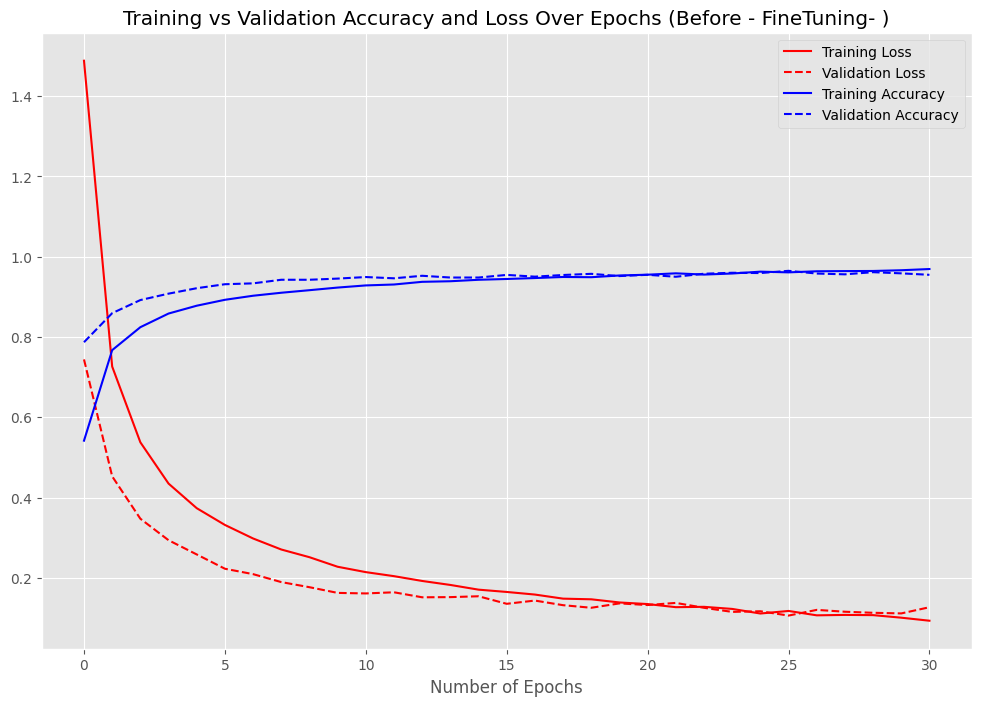

In [23]:
# Get the training history
h = hist.history

# Set plotting style
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
plt.title("Training vs Validation Accuracy and Loss Over Epochs (Before - FineTuning- )")

# Plot training and validation loss
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')

# Plot training and validation accuracy
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')

plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

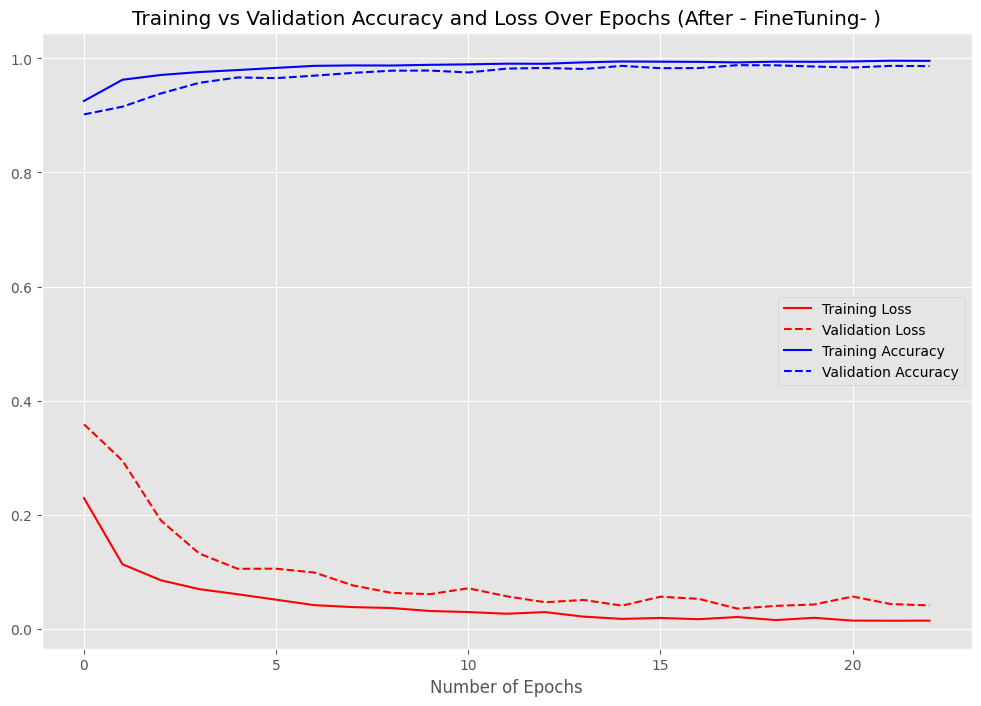

In [24]:
# Get the training history
h = fine_tune_history.history

# Set plotting style
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
plt.title("Training vs Validation Accuracy and Loss Over Epochs (After - FineTuning- )")


# Plot training and validation loss
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')

# Plot training and validation accuracy
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')

plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [25]:
def PredictImageFromPath(image_path,actual):

     # Load and preprocess the image
    img = load_img(image_path, target_size=(WIDTH,HEIGHT))
    img_array = preprocess_input(img_to_array(img))
    img_array_exp = np.expand_dims(img_array, axis=0) # Add batch dimension

    # Make prediction
    pred = model_after.predict(img_array_exp, verbose=0)
    class_index = np.argmax(pred, axis=1)[0]
    label = class_names[class_index]    

    # Display the image with predicted label
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Predicted: {label} \n Actual: {actual}")
    plt.axis('off')
    plt.show()
    

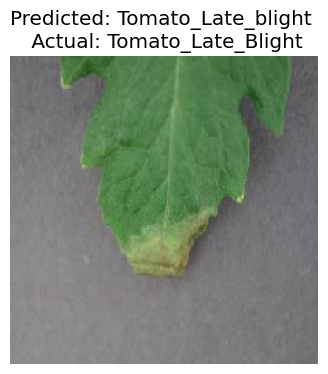

In [28]:
PredictImageFromPath("/kaggle/working/plantdisease_split/val/Tomato_Late_blight/013f987a-9371-4763-a104-ea6f326e584b___GHLB2 Leaf 8556.JPG","Tomato_Late_Blight")
